#Clean the content area

In [ ]:
!rm -rf /content/*

#Useful

##Deeply clean the social media contents

In [ ]:
import pandas as pd
import os
import re
from google.colab import files

file_names = [
    'wallstreetbets_AMC.xlsx',
    'wallstreetbets_BB.xlsx',
    'wallstreetbets_GME.xlsx',
    'wallstreetbets_Koss.xlsx',
]

def clean_text(text):
    if not isinstance(text, str):
        return text
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'\n+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\W+', ' ', text)
    text = re.sub(r'\d+', '', text)
    return text.strip()

for file_name in file_names:
    try:
        df = pd.read_excel(file_name, sheet_name=None)
    except FileNotFoundError:
        print(f"File {file_name} not found. Skipping...")
        continue

    posts = df['Sheet1'][[
        'post_created', 'post_title', 'post_body', 'poster_name', 'post_score', 'num_comments'
    ]].rename(columns={
        'post_created': 'date',
        'poster_name': 'creater',
        'post_score': 'likes',
        'num_comments': 'influence'
    })
    posts['type'] = 'p'
    posts['content'] = posts['post_title'].fillna('') + " " + posts['post_body'].fillna('')
    posts['content'] = posts['content'].apply(clean_text)

    comments = df['Sheet1'][[
        'comment_created', 'comment_body', 'commenter_name', 'comment_score', 'num_replies'
    ]].rename(columns={
        'comment_created': 'date',
        'comment_body': 'content',
        'commenter_name': 'creater',
        'comment_score': 'likes',
        'num_replies': 'influence'
    })
    comments['type'] = 'c'
    comments['content'] = comments['content'].apply(clean_text)

    replies = df['Sheet1'][[
        'reply_created', 'reply_body', 'replier_name', 'reply_score'
    ]].rename(columns={
        'reply_created': 'date',
        'reply_body': 'content',
        'replier_name': 'creater',
        'reply_score': 'likes'
    })
    replies['type'] = 'r'
    replies['influence'] = 0
    replies['content'] = replies['content'].apply(clean_text)

    combined_data = pd.concat([posts, comments, replies])

    combined_data['total_impact'] = combined_data['likes'] + combined_data['influence']

    combined_data = combined_data[(combined_data['content'] != 'deleted') & (combined_data['content'] != 'delete') & (combined_data['content'] != '')]

    combined_data.sort_values('type', ascending=False, inplace=True)
    combined_data = combined_data.drop_duplicates(subset=['date', 'content', 'creater'], keep='first')


    combined_data = combined_data[['date', 'type', 'content', 'creater', 'likes', 'influence', 'total_impact']].drop_duplicates().sort_values('date')

    name_part, extension = os.path.splitext(file_name)
    new_file_name = name_part + '_cleaned' + extension

    combined_data.to_excel(new_file_name, index=False)

    print(f"Data processed and saved successfully to {new_file_name}.")

    files.download(new_file_name)

Data processed and saved successfully to wallstreetbets_AMC_cleaned.xlsx.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Data processed and saved successfully to wallstreetbets_BB_cleaned.xlsx.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Data processed and saved successfully to wallstreetbets_GME_cleaned.xlsx.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Data processed and saved successfully to wallstreetbets_Koss_cleaned.xlsx.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##Adding the sentiment polarity and subjectivity

In [ ]:
import pandas as pd
import os
from google.colab import files
from textblob import TextBlob


file_names = [
    'wallstreetbets_AMC_cleaned.xlsx',
    'wallstreetbets_BB_cleaned.xlsx',
    'wallstreetbets_GME_cleaned.xlsx',
    'wallstreetbets_Koss_cleaned.xlsx',
]

def get_polarity(text):

    blob = TextBlob(str(text))

    return blob.sentiment.polarity


def get_subjectivity(text):

    blob = TextBlob(str(text))

    return blob.sentiment.subjectivity


for file_name in file_names:

    try:
        dfs = pd.read_excel(file_name, sheet_name=None)
        combined_data = pd.concat(dfs.values())
    except FileNotFoundError:
        print(f"File {file_name} not found. Skipping...")
        continue
    except ValueError as e:
        print(f"Error processing {file_name}: {e}")
        continue




    combined_data['polarity score'] = combined_data['content'].apply(get_polarity)
    combined_data['subjectivity score'] = combined_data['content'].apply(get_subjectivity)


    name_part, extension = os.path.splitext(file_name)
    new_file_name = name_part + '_sentiment' + extension


    combined_data.to_excel(new_file_name, index=False)


    print(f"Data processed and saved successfully to {new_file_name}.")

    files.download(new_file_name)


Data processed and saved successfully to wallstreetbets_AMC_cleaned_sentiment.xlsx.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Data processed and saved successfully to wallstreetbets_BB_cleaned_sentiment.xlsx.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Data processed and saved successfully to wallstreetbets_GME_cleaned_sentiment.xlsx.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Data processed and saved successfully to wallstreetbets_Koss_cleaned_sentiment.xlsx.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##Cleaning the stock prices files

##Marking anomalies

In [ ]:
import pandas as pd
import os
from google.colab import files


file_paths = [
    'Bloomberg_AMC_cleaned.xlsx',
    'Bloomberg_BB_cleaned.xlsx',
    'Bloomberg_GameStop_cleaned.xlsx',
    'Bloomberg_KOSS_cleaned.xlsx'
]

def detect_and_flag_anomalies(file_path, window_hours=12):
    df = pd.read_excel(file_path)

    df['Date'] = pd.to_datetime(df['Date'])

    window = window_hours * 60
    rolling_mean = df['Last Price'].rolling(window=window, min_periods=1).mean()
    rolling_std = df['Last Price'].rolling(window=window, min_periods=1).std()


    threshold = 2
    z_score = (df['Last Price'] - rolling_mean) / rolling_std
    df['Price Anomalies'] = z_score.apply(lambda x: 'i' if x > threshold else ('d' if x < -threshold else ''))

    if 'Volume' in df.columns:
        rolling_mean_vol = df['Volume'].rolling(window=window, min_periods=1).mean()
        rolling_std_vol = df['Volume'].rolling(window=window, min_periods=1).std()
        z_score_vol = (df['Volume'] - rolling_mean_vol) / rolling_std_vol
        df['Volume Anomalies'] = z_score_vol.apply(lambda x: 'i' if x > threshold else ('d' if x < -threshold else ''))


    new_file_path = os.path.splitext(file_path)[0] + '_flagged.xlsx'
    df.to_excel(new_file_path, index=False)
    print(f"Processed and saved {new_file_path}")


    files.download(new_file_path)

for path in file_paths:
    detect_and_flag_anomalies(path)


Processed and saved Bloomberg_AMC_cleaned_flagged.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Processed and saved Bloomberg_BB_cleaned_flagged.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Processed and saved Bloomberg_GameStop_cleaned_flagged.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Processed and saved Bloomberg_KOSS_cleaned_flagged.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##Merging files

In [ ]:
import pandas as pd
from google.colab import files


stock_map = {
    'AMC': 'AMC',
    'BB': 'BB',
    'GameStop': 'GME',
    'KOSS': 'Koss'
}

base_path = '/content/'


for stock_name, post in stock_map.items():

    bloomberg_path = f'{base_path}Bloomberg_{stock_name}_cleaned_flagged.xlsx'
    wallstreetbets_path = f'{base_path}wallstreetbets_{post}_cleaned_sentiment.xlsx'

    bloomberg_data = pd.read_excel(bloomberg_path)
    data = pd.read_excel(wallstreetbets_path)


    data['date'] = pd.to_datetime(data['date']).dt.floor('T')
    bloomberg_data['Date'] = pd.to_datetime(bloomberg_data['Date']).dt.floor('T')


    summary = data.groupby(['date', 'type']).size().unstack(fill_value=0).rename(columns={'p': 'post_num', 'c': 'comment_num', 'r': 'reply_num'})
    likes_influence = data.groupby('date').agg({'likes': 'sum', 'influence': 'sum'}).rename(columns={'likes': 'total_like', 'influence': 'total_influence'})

    polarity = data.groupby('date')['polarity score'].mean().rename('polarity')
    subjectivity = data.groupby('date')['subjectivity score'].mean().rename('subjectivity')
    minute_summary = pd.concat([summary, likes_influence, polarity, subjectivity], axis=1)
    minute_summary.reset_index(inplace=True)
    minute_summary.rename(columns={'date': 'Date'}, inplace=True)


    merged_data = pd.merge(bloomberg_data, minute_summary, on='Date', how='left')
    merged_data.sort_values('Date', inplace=True)
    merged_data.fillna(0, inplace=True)


    output_file_name = f'{post.upper()}_merged.xlsx'
    output_path = f'{base_path}{output_file_name}'
    merged_data.to_excel(output_path, index=False)

    files.download(output_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##Some visualisation

In [ ]:
!pip install pandas seaborn matplotlib

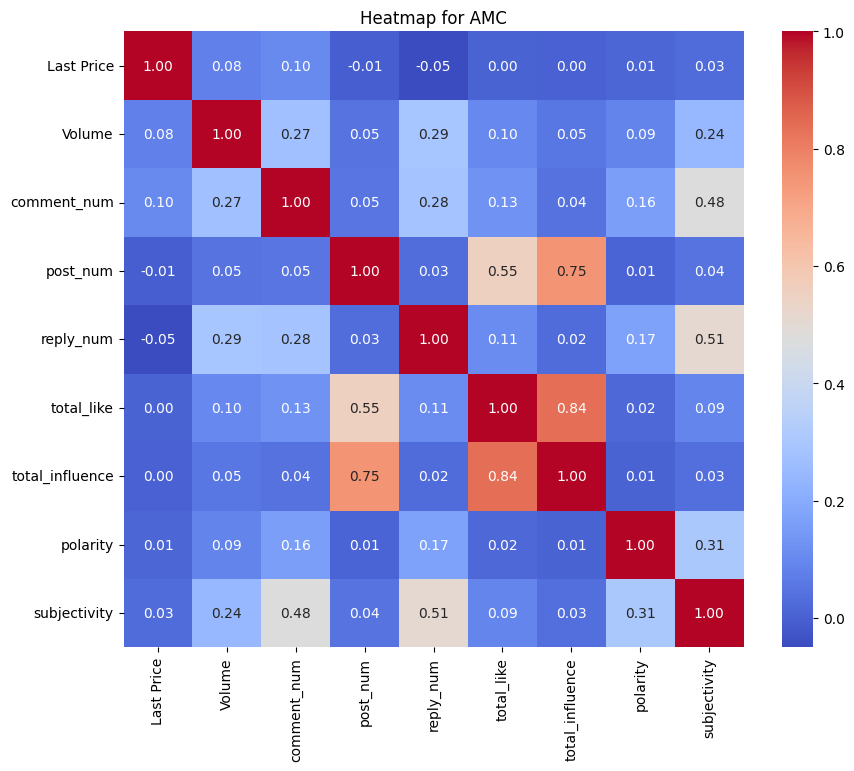

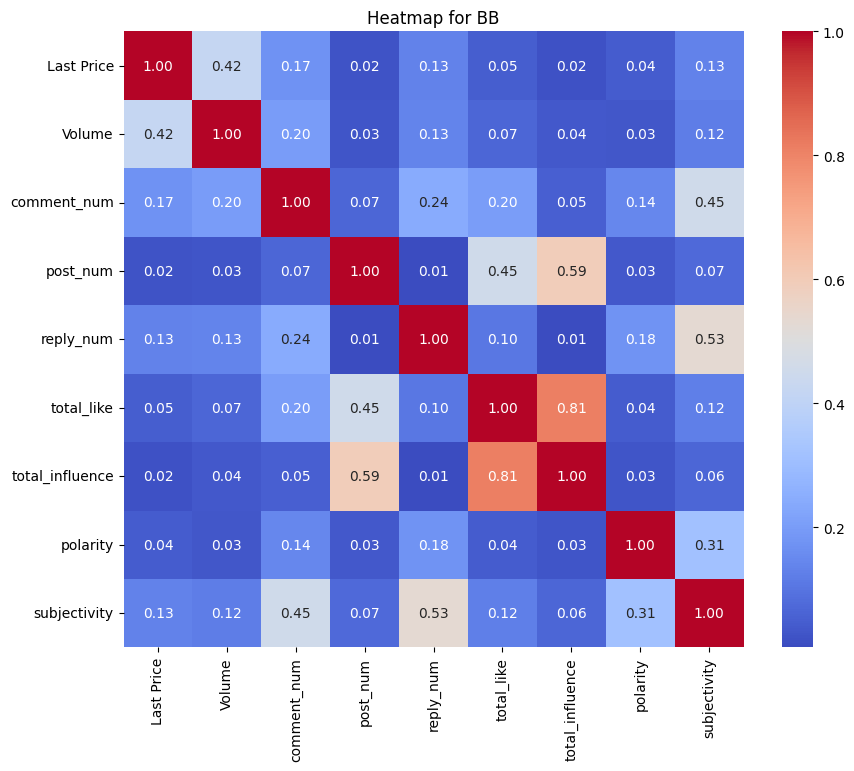

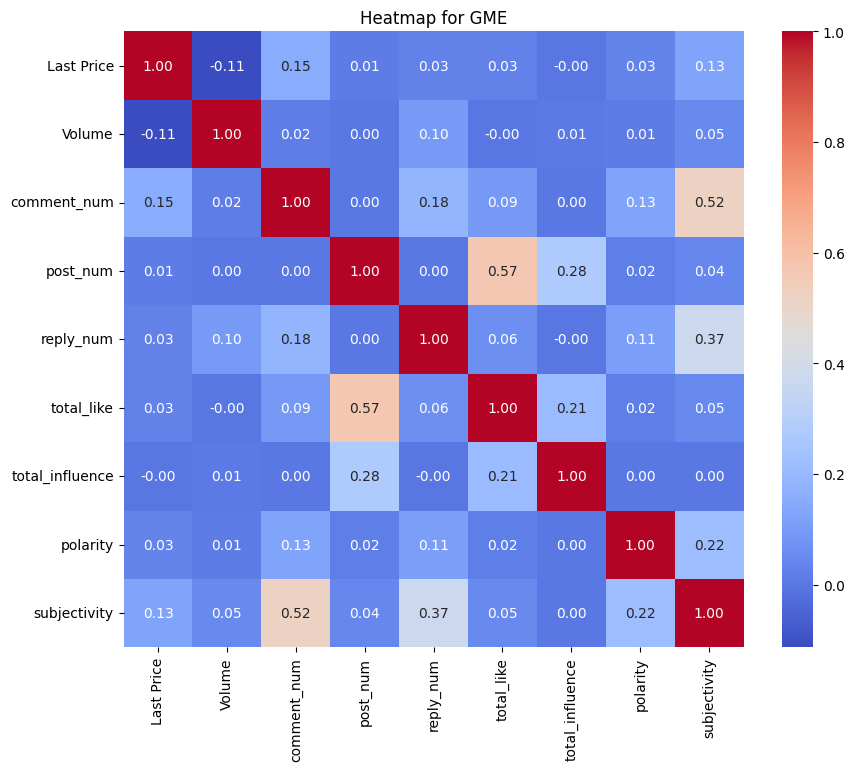

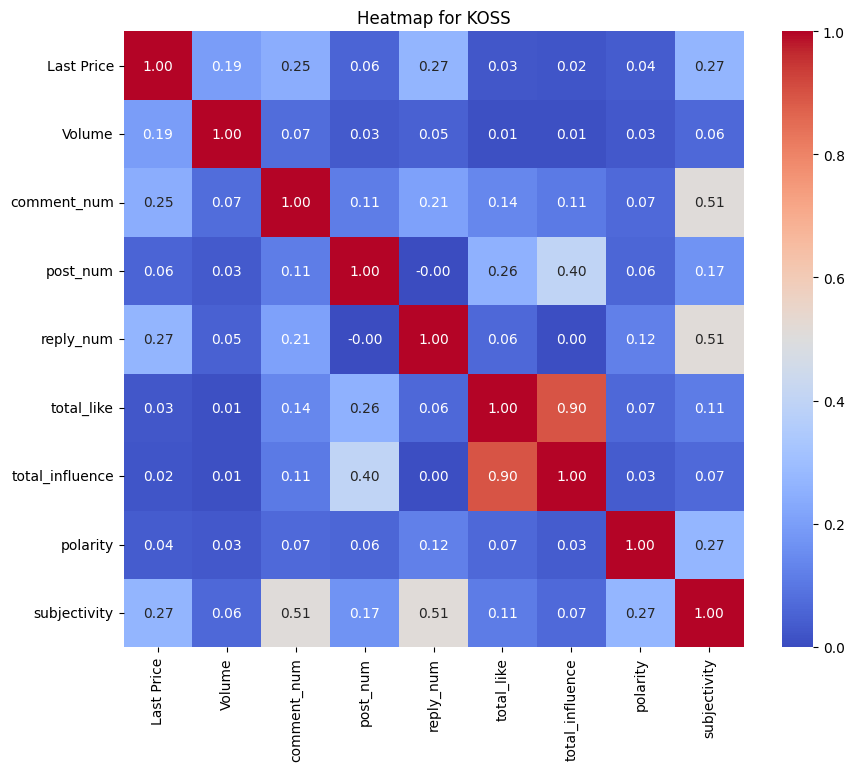

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


file_paths = [
    'AMC_merged.xlsx',
    'BB_merged.xlsx',
    'GME_merged.xlsx',
    'KOSS_merged.xlsx'
]


for file_path in file_paths:

    df = pd.read_excel(file_path)


    numeric_cols = df.select_dtypes(include=[np.number]).columns
    correlation_matrix = df[numeric_cols].corr()


    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)


    plt.title(f"Heatmap for {file_path.split('/')[-1].split('_')[0]}")


    plt.show()


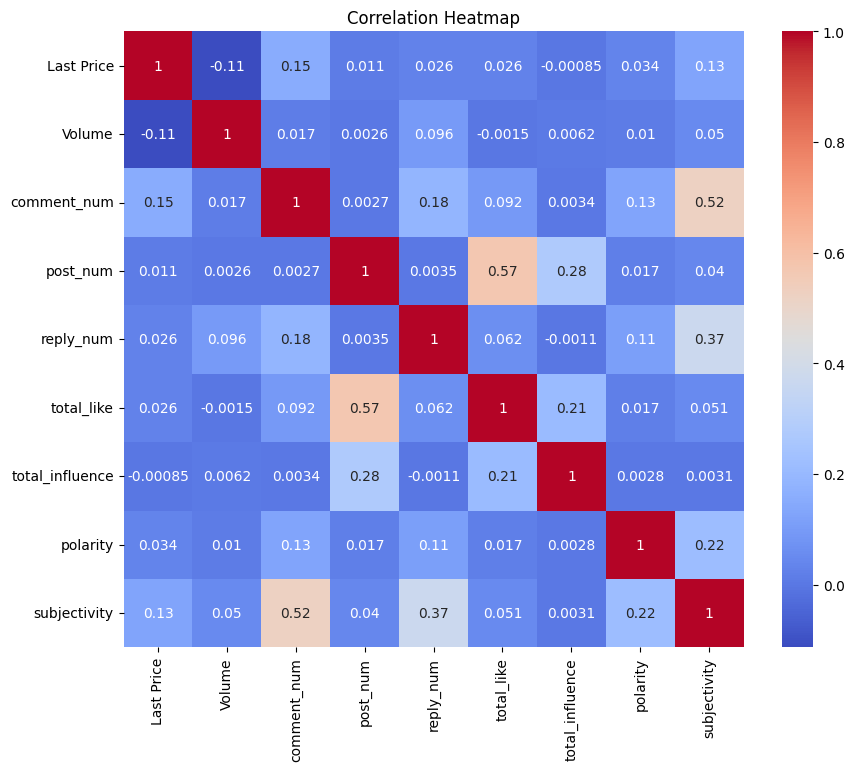

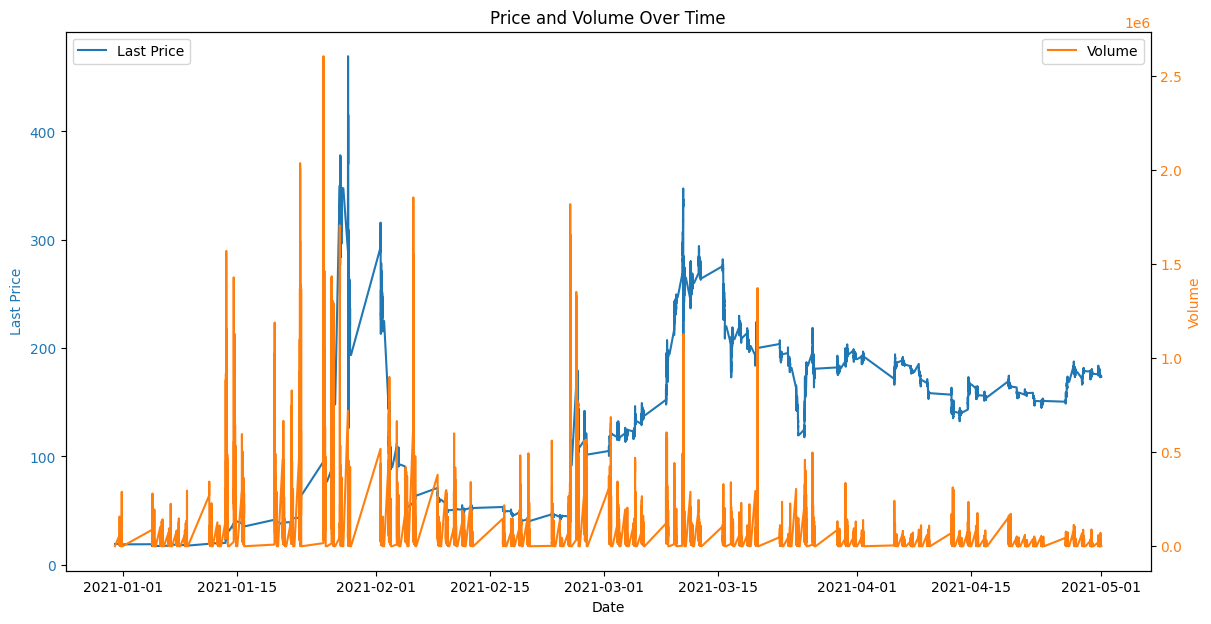

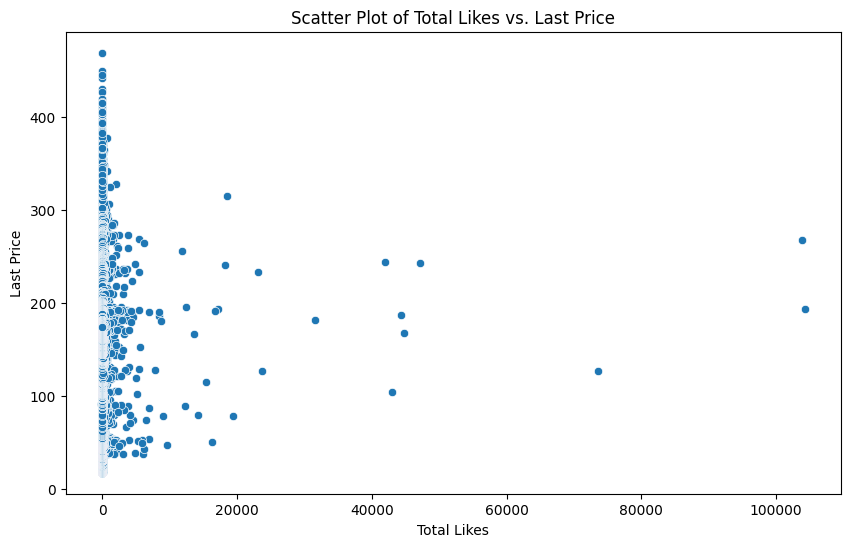

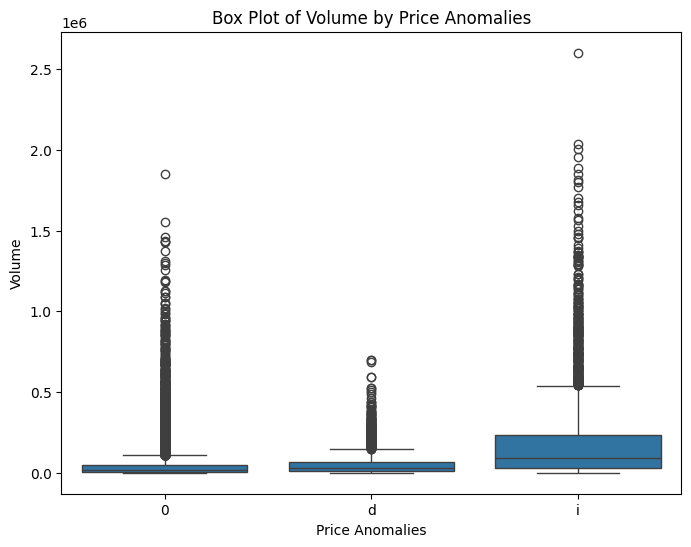

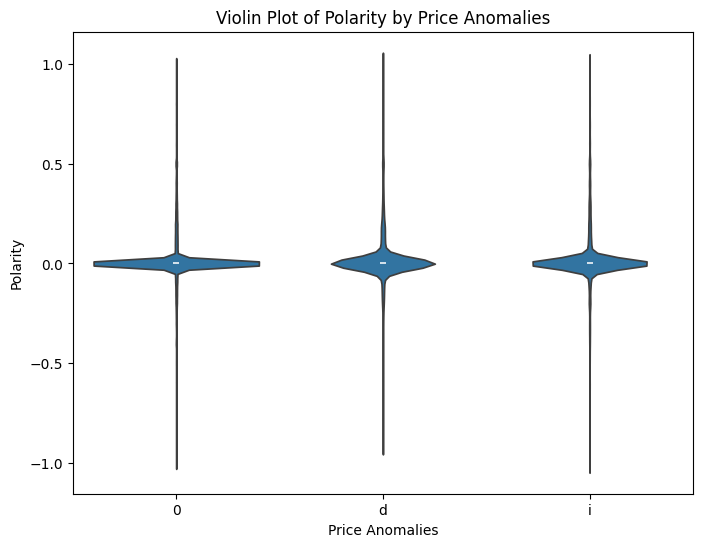

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 加载数据
file_path = 'GME_merged.xlsx'
data = pd.read_excel(file_path)

# 热力图：显示相关性
plt.figure(figsize=(10, 8))
sns.heatmap(data[['Last Price', 'Volume', 'comment_num', 'post_num', 'reply_num', 'total_like', 'total_influence', 'polarity', 'subjectivity']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# 时间序列图：展示价格和交易量随时间的变化
fig, ax1 = plt.subplots(figsize=(14, 7))
ax2 = ax1.twinx()  # 创建第二个坐标轴
ax1.plot(data['Date'], data['Last Price'], label='Last Price', color='tab:blue')
ax2.plot(data['Date'], data['Volume'], label='Volume', color='tab:orange')

ax1.set_xlabel('Date')
ax1.set_ylabel('Last Price', color='tab:blue')
ax2.set_ylabel('Volume', color='tab:orange')

ax1.tick_params(axis='y', labelcolor='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:orange')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.title('Price and Volume Over Time')
plt.show()

# 散点图：展示总点赞数与最后成交价之间的关系
plt.figure(figsize=(10, 6))
sns.scatterplot(x='total_like', y='Last Price', data=data)
plt.title('Scatter Plot of Total Likes vs. Last Price')
plt.xlabel('Total Likes')
plt.ylabel('Last Price')
plt.show()

# 箱形图：比较有无价格异常的交易量
plt.figure(figsize=(8, 6))
sns.boxplot(x='Price Anomalies', y='Volume', data=data)
plt.title('Box Plot of Volume by Price Anomalies')
plt.xlabel('Price Anomalies')
plt.ylabel('Volume')
plt.show()

# 小提琴图：展示情感倾向的分布
plt.figure(figsize=(8, 6))
sns.violinplot(x='Price Anomalies', y='polarity', data=data)
plt.title('Violin Plot of Polarity by Price Anomalies')
plt.xlabel('Price Anomalies')
plt.ylabel('Polarity')
plt.show()


##Training the model

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import joblib

def load_data(file_path):
    try:
        data = pd.read_excel(file_path)
        data['Date'] = pd.to_datetime(data['Date'])
        return data
    except Exception as e:
        print(f"Error loading data from {file_path}: {e}")
        return pd.DataFrame()

def prepare_features(data, window_size=720):
    data.sort_values(by='Date', inplace=True)
    data['Label'] = 0
    data.loc[data['Price Anomalies'] == 'i', 'Label'] = 1
    data.loc[data['Price Anomalies'] == 'd', 'Label'] = 2
    data.loc[data['Volume Anomalies'] == 'i', 'Label'] = 3

    global_sums = data[['comment_num', 'post_num', 'reply_num', 'total_like', 'total_influence']].sum()
    global_count = len(data)
    global_avgs = {
        'comment_num': global_sums['comment_num'] / global_count * window_size,
        'post_num': global_sums['post_num'] / global_count * window_size,
        'reply_num': global_sums['reply_num'] / global_count * window_size,
        'total_like': global_sums['total_like'] / global_count * window_size,
        'total_influence': global_sums['total_influence'] / global_count * window_size,
        'polarity': data['polarity'].mean(),
        'subjectivity': data['subjectivity'].mean()
    }

    features_list = []
    for i in range(window_size, len(data)):
        current_window = data.iloc[i-window_size:i]
        current_features = {
            'comment_num': current_window['comment_num'].sum(),
            'post_num': current_window['post_num'].sum(),
            'reply_num': current_window['reply_num'].sum(),
            'total_like': current_window['total_like'].sum(),
            'total_influence': current_window['total_influence'].sum(),
            'polarity': current_window['polarity'].mean(),
            'subjectivity': current_window['subjectivity'].mean()
        }

        diff_features = [
            current_features['comment_num'] - global_avgs['comment_num'],
            current_features['post_num'] - global_avgs['post_num'],
            current_features['reply_num'] - global_avgs['reply_num'],
            current_features['total_like'] - global_avgs['total_like'],
            current_features['total_influence'] - global_avgs['total_influence'],
            current_features['polarity'] - global_avgs['polarity'],
            current_features['subjectivity'] - global_avgs['subjectivity']
        ]

        features_list.append(diff_features)

    features = pd.DataFrame(features_list, columns=[
        'Diff_Total_Comment_Num',
        'Diff_Total_Post_Num',
        'Diff_Total_Reply_Num',
        'Diff_Total_Likes',
        'Diff_Total_Influence',
        'Diff_Avg_Polarity',
        'Diff_Avg_Subjectivity'
    ])

    labels = data['Label'].iloc[window_size:].reset_index(drop=True)
    return features, labels

def train_and_collect_predictions(X, y, models, model_save_path, model_counter):
    if X.empty or y.empty:
        print("Empty features or labels.")
        return model_counter

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

    for name, model in models.items():
        try:
            model.fit(X_train, y_train)
            model_filename = f"model{model_counter}.pkl"
            joblib.dump(model, os.path.join(model_save_path, model_filename))
            print(f"Results for {name} (saved as {model_filename}):")
            print(classification_report(y_test, model.predict(X_test)))
            model_counter += 1
        except Exception as e:
            print(f"Error training {name}: {e}")

    return model_counter

def batch_process_and_train_models(file_paths, model_save_path):
    models = {
        "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
        "GradientBoosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
        "KNN": KNeighborsClassifier()
    }
    model_counter = 1

    for file_path in file_paths:
        dataset_name = os.path.splitext(os.path.basename(file_path))[0]
        print(f"Processing {dataset_name}")
        data = load_data(file_path)
        if data.empty:
            continue
        X, y = prepare_features(data)
        model_counter = train_and_collect_predictions(X, y, models, model_save_path, model_counter)

if __name__ == "__main__":
    merged_file_paths = [
        'AMC_merged.xlsx',
        'BB_merged.xlsx',
        'GME_merged.xlsx',
        'KOSS_merged.xlsx'
    ]
    model_save_path = '/content'
    batch_process_and_train_models(merged_file_paths, model_save_path)


Processing AMC_merged
Results for RandomForest (saved as model1.pkl):
              precision    recall  f1-score   support

           0       0.86      0.99      0.92     12032
           1       0.78      0.44      0.56       927
           2       0.86      0.22      0.35      1099
           3       0.64      0.22      0.33       867

    accuracy                           0.86     14925
   macro avg       0.78      0.47      0.54     14925
weighted avg       0.84      0.86      0.82     14925

Results for GradientBoosting (saved as model2.pkl):
              precision    recall  f1-score   support

           0       0.85      1.00      0.92     12032
           1       0.74      0.38      0.50       927
           2       0.85      0.19      0.31      1099
           3       0.70      0.11      0.18       867

    accuracy                           0.85     14925
   macro avg       0.78      0.42      0.48     14925
weighted avg       0.84      0.85      0.80     14925

Results 

##Visualising and analysing the results

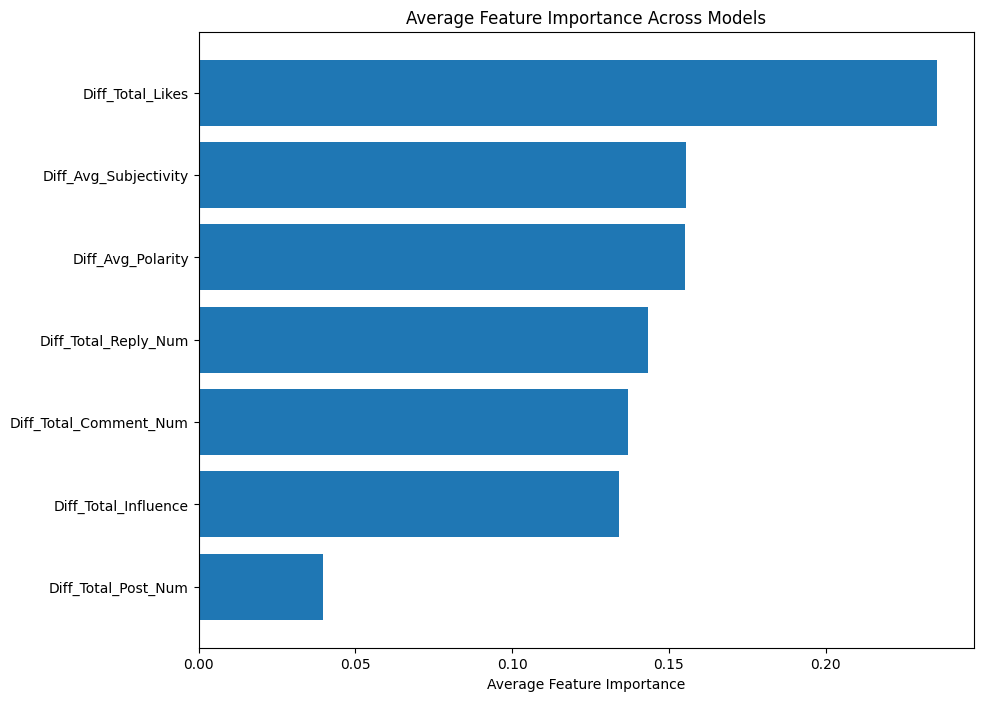

In [ ]:
import os
import joblib
import numpy as np
import matplotlib.pyplot as plt

def load_models_and_extract_importances(model_save_path):
    feature_importances = []
    for filename in os.listdir(model_save_path):
        if filename.endswith('.pkl'):
            model = joblib.load(os.path.join(model_save_path, filename))

            if hasattr(model, 'feature_importances_'):
                feature_importances.append(model.feature_importances_)
    return np.array(feature_importances)

def plot_feature_importances(feature_importances, feature_names):

    mean_importances = np.mean(feature_importances, axis=0)

    plt.figure(figsize=(10, 8))
    sorted_idx = np.argsort(mean_importances)
    plt.barh(range(len(mean_importances)), mean_importances[sorted_idx], align='center')
    plt.yticks(range(len(mean_importances)), np.array(feature_names)[sorted_idx])
    plt.xlabel('Average Feature Importance')
    plt.title('Average Feature Importance Across Models')
    plt.show()

feature_names = ['Diff_Total_Comment_Num', 'Diff_Total_Post_Num', 'Diff_Total_Reply_Num', 'Diff_Total_Likes', 'Diff_Total_Influence', 'Diff_Avg_Polarity', 'Diff_Avg_Subjectivity']
model_save_path = '/content'
importances = load_models_and_extract_importances(model_save_path)
plot_feature_importances(importances, feature_names)


In [ ]:
!pip install prettytable

In [ ]:
import numpy as np
from prettytable import PrettyTable

def compare_models():
    # F1 scores for Random Forest
    rf_f1_scores = {
        'class_0': np.mean([0.92, 0.93, 0.97, 0.92]),
        'class_1': np.mean([0.56, 0.54, 0.82, 0.33]),
        'class_2': np.mean([0.35, 0.54, 0.79, 0.05]),
        'class_3': np.mean([0.33, 0.22, 0.51, 0.10])
    }

    # F1 scores for Gradient Boosting
    gb_f1_scores = {
        'class_0': np.mean([0.92, 0.91, 0.94, 0.92]),
        'class_1': np.mean([0.50, 0.28, 0.71, 0.34]),
        'class_2': np.mean([0.31, 0.27, 0.61, 0.04]),
        'class_3': np.mean([0.18, 0.10, 0.15, 0.08])
    }

    # F1 scores for K-Nearest Neighbors
    knn_f1_scores = {
        'class_0': np.mean([0.92, 0.93, 0.96, 0.92]),
        'class_1': np.mean([0.55, 0.53, 0.80, 0.33]),
        'class_2': np.mean([0.35, 0.52, 0.79, 0.04]),
        'class_3': np.mean([0.32, 0.20, 0.46, 0.08])
    }

    # Create table
    table = PrettyTable()
    table.field_names = ["Class", "Random Forest", "Gradient Boosting", "K-Nearest Neighbors"]
    classes = ['class_0', 'class_1', 'class_2', 'class_3']
    for cls in classes:
        row = [cls.split('_')[-1], rf_f1_scores[cls], gb_f1_scores[cls], knn_f1_scores[cls]]
        table.add_row(row)

    print(table)

    # Compare F1 scores and determine the best model for each class
    model_scores = {'RF': rf_f1_scores, 'GB': gb_f1_scores, 'KNN': knn_f1_scores}
    best_models = {}
    for cls in classes:
        best_model = max(['RF', 'GB', 'KNN'], key=lambda x: model_scores[x][cls])
        best_models[cls] = best_model

    # Output the best models for each class
    for cls, model in best_models.items():
        class_index = cls.split('_')[-1]
        print(f"Best Model for Class {class_index}: {model}")

if __name__ == "__main__":
    compare_models()


+-------+---------------------+-------------------+---------------------+
| Class |    Random Forest    | Gradient Boosting | K-Nearest Neighbors |
+-------+---------------------+-------------------+---------------------+
|   0   |        0.935        |       0.9225      |        0.9325       |
|   1   |        0.5625       |       0.4575      |        0.5525       |
|   2   | 0.43250000000000005 |       0.3075      | 0.42500000000000004 |
|   3   | 0.29000000000000004 |       0.1275      |        0.265        |
+-------+---------------------+-------------------+---------------------+
Best Model for Class 0: RF
Best Model for Class 1: RF
Best Model for Class 2: RF
Best Model for Class 3: RF


##Using the model

In [ ]:
!pip install praw

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.0/191.0 kB 4.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import os
import re
from datetime import datetime
from textblob import TextBlob
import praw
import logging
import joblib  # Make sure to import joblib for loading models
from datetime import datetime, timedelta
import prawcore

import warnings
warnings.filterwarnings('ignore')


logging.getLogger('praw').setLevel(logging.CRITICAL)

reddit = praw.Reddit(
    client_id='kCJ_OEEEHKneOEitdIUWfg',
    client_secret='5NOQnb3mmwXVtQwf0tp8FbIgdjvxPA',
    user_agent='MarketTeam'
)


def fetch_posts_comments_replies(subreddit_name, keywords, post_limit=None, comment_limit=None, reply_limit=None):
    print(f"Fetching posts for subreddit {subreddit_name} with keywords {keywords}...")
    subreddit = reddit.subreddit(subreddit_name)
    data = []
    query = " OR ".join(keywords)

    try:
        for submission in subreddit.search(query, limit=post_limit):
            poster_name = submission.author.name if submission.author else "Deleted"
            post_info = {
                "post_title": submission.title,
                "post_score": submission.score,
                "post_id": submission.id,
                "post_url": submission.url,
                "post_created": datetime.utcfromtimestamp(submission.created_utc).strftime('%Y-%m-%d %H:%M:%S'),
                "num_comments": submission.num_comments,
                "post_body": submission.selftext,
                "poster_name": poster_name,
                "comment_id": "",
                "comment_body": "",
                "comment_score": "",
                "comment_created": "",
                "commenter_name": "",
                "num_replies": "",
                "reply_id": "",
                "reply_body": "",
                "reply_score": "",
                "reply_created": "",
                "replier_name": ""
            }

            submission.comments.replace_more(limit=0)
            for comment in submission.comments.list()[:comment_limit]:
                commenter_name = comment.author.name if comment.author else "Deleted"
                comment_info = post_info.copy()
                comment_info.update({
                    "comment_id": comment.id,
                    "comment_body": comment.body,
                    "comment_score": comment.score,
                    "comment_created": datetime.utcfromtimestamp(comment.created_utc).strftime('%Y-%m-%d %H:%M:%S'),
                    "commenter_name": commenter_name,
                    "num_replies": len(comment.replies)
                })

                data.append(comment_info)

                replies = comment.replies.list() if hasattr(comment, 'replies') else []
                for reply in replies[:reply_limit]:
                    replier_name = reply.author.name if reply.author else "Deleted"
                    reply_info = comment_info.copy()
                    reply_info.update({
                        "reply_id": reply.id,
                        "reply_body": reply.body,
                        "reply_score": reply.score,
                        "reply_created": datetime.utcfromtimestamp(reply.created_utc).strftime('%Y-%m-%d %H:%M:%S'),
                        "replier_name": replier_name
                    })

                    data.append(reply_info)

    except prawcore.exceptions.ServerError:
        print("A server error occurred. Please try again later.")
        return None  # Return None to indicate failure to fetch data

    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None  # General catch for other exceptions

    return pd.DataFrame(data)


def first_clean(df):
    print("Processing data...")

    posts = df[[
        'post_created', 'post_title', 'post_body', 'poster_name', 'post_score', 'num_comments'
    ]].rename(columns={
        'post_created': 'date',
        'poster_name': 'creater',
        'post_score': 'likes',
        'num_comments': 'influence'
    })
    posts['type'] = 'p'
    posts['content'] = posts['post_title'].fillna('') + " " + posts['post_body'].fillna('')
    posts['content'] = posts['content'].apply(second_clean)


    comments = df[[
        'comment_created', 'comment_body', 'commenter_name', 'comment_score', 'num_replies'
    ]].rename(columns={
        'comment_created': 'date',
        'comment_body': 'content',
        'commenter_name': 'creater',
        'comment_score': 'likes',
        'num_replies': 'influence'
    })
    comments['type'] = 'c'
    comments['content'] = comments['content'].apply(second_clean)


    replies = df[[
        'reply_created', 'reply_body', 'replier_name', 'reply_score'
    ]].rename(columns={
        'reply_created': 'date',
        'reply_body': 'content',
        'replier_name': 'creater',
        'reply_score': 'likes'
    })
    replies['type'] = 'r'
    replies['influence'] = 0
    replies['content'] = replies['content'].apply(second_clean)

    combined_data = pd.concat([posts, comments, replies])

    combined_data = combined_data[(combined_data['content'] != 'deleted') & (combined_data['content'] != 'delete') & (combined_data['content'] != '')]


    combined_data.sort_values('type', ascending=False, inplace=True)  # This ensures 'c' types are first
    combined_data = combined_data.drop_duplicates(subset=['date', 'content', 'creater'], keep='first')


    combined_data = combined_data[['date', 'type', 'content', 'creater', 'likes', 'influence']].drop_duplicates().sort_values('date')

    return combined_data

def second_clean(text):
    if not isinstance(text, str):
        return text
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'\n+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\W+', ' ', text)
    text = re.sub(r'\d+', '', text)
    return text.strip()

def add_sentiment(df):
    print("Analysing sentiment...")
    df['polarity score'] = df['content'].apply(lambda text: TextBlob(str(text)).sentiment.polarity)
    df['subjectivity score'] = df['content'].apply(lambda text: TextBlob(str(text)).sentiment.subjectivity)
    return df


def third_clean(data):
    print("Preparing data for final analysis...")

    data['date'] = pd.to_datetime(data['date']).dt.floor('min')

    end_date = datetime.now().replace(second=0, microsecond=0)
    start_date = end_date - timedelta(days=180)

    date_range = pd.date_range(start=start_date, end=end_date, freq='min')

    time_series_df = pd.DataFrame(date_range, columns=['Date'])

    data = data[(data['date'] >= start_date) & (data['date'] <= end_date)]

    if 'type' in data.columns:
        summary = data.groupby([pd.Grouper(key='date', freq='min'), 'type']).size().unstack(fill_value=0).rename(columns={'p': 'post_num', 'c': 'comment_num', 'r': 'reply_num'})
    else:
        summary = pd.DataFrame(index=date_range)
        summary['post_num'] = 0
        summary['comment_num'] = 0
        summary['reply_num'] = 0

    likes_influence = data.groupby(pd.Grouper(key='date', freq='min')).agg({'likes': 'sum', 'influence': 'sum'}).rename(columns={'likes': 'total_like', 'influence': 'total_influence'})
    polarity = data.groupby(pd.Grouper(key='date', freq='min'))['polarity score'].mean().rename('polarity')
    subjectivity = data.groupby(pd.Grouper(key='date', freq='min'))['subjectivity score'].mean().rename('subjectivity')

    minute_summary = pd.concat([summary, likes_influence, polarity, subjectivity], axis=1).reset_index().rename(columns={'date': 'Date'})

    merged_data = pd.merge(time_series_df, minute_summary, on='Date', how='left')

    expected_columns = ['comment_num', 'post_num', 'reply_num', 'total_like', 'total_influence', 'polarity', 'subjectivity']
    for col in expected_columns:
        if col not in merged_data.columns:
            merged_data[col] = 0

    merged_data.fillna(0, inplace=True)

    return merged_data


def prepare_features(data, window_size=720):
    data.sort_values(by='Date', inplace=True)
    global_sums = data[['comment_num', 'post_num', 'reply_num', 'total_like', 'total_influence']].sum()
    global_count = len(data)
    global_avgs = {
        'comment_num': global_sums['comment_num'] / global_count * window_size,
        'post_num': global_sums['post_num'] / global_count * window_size,
        'reply_num': global_sums['reply_num'] / global_count * window_size,
        'total_like': global_sums['total_like'] / global_count * window_size,
        'total_influence': global_sums['total_influence'] / global_count * window_size,
        'polarity': data['polarity'].mean(),
        'subjectivity': data['subjectivity'].mean()
    }

    features_list = []
    for i in range(window_size, len(data)):
        current_window = data.iloc[i-window_size:i]
        current_features = {
            'comment_num': current_window['comment_num'].sum(),
            'post_num': current_window['post_num'].sum(),
            'reply_num': current_window['reply_num'].sum(),
            'total_like': current_window['total_like'].sum(),
            'total_influence': current_window['total_influence'].sum(),
            'polarity': current_window['polarity'].mean(),
            'subjectivity': current_window['subjectivity'].mean()
        }

        diff_features = [
            current_features['comment_num'] - global_avgs['comment_num'],
            current_features['post_num'] - global_avgs['post_num'],
            current_features['reply_num'] - global_avgs['reply_num'],
            current_features['total_like'] - global_avgs['total_like'],
            current_features['total_influence'] - global_avgs['total_influence'],
            current_features['polarity'] - global_avgs['polarity'],
            current_features['subjectivity'] - global_avgs['subjectivity']
        ]

        features_list.append(diff_features)

    return pd.DataFrame(features_list, columns=[
        'Diff_Total_Comment_Num',
        'Diff_Total_Post_Num',
        'Diff_Total_Reply_Num',
        'Diff_Total_Likes',
        'Diff_Total_Influence',
        'Diff_Avg_Polarity',
        'Diff_Avg_Subjectivity'
    ])


def load_models():
    print("Loading models...")
    models = {}
    rf_models = ['model1', 'model4', 'model7', 'model10']
    for i in rf_models:
        model_filename = f'{i}.pkl'
        models[i] = joblib.load(os.path.join('/content', model_filename))
    return models

def predict(models, features):
    print("Predicting behaviour...")
    predictions = {}
    class_labels = ["Stable or small fluctuations", "Abnormal price increase", "Abnormal price decrease", "Abnormal trading volume increase"]
    for name, model in models.items():
        proba = model.predict_proba(features)
        predictions[name] = dict(zip(class_labels, proba[0]))
    return predictions

def calculate_weighted_averages(predictions):
    weights = {name: 1.0 / len(predictions) for name in predictions}
    final_averages = {key: 0 for key in predictions[next(iter(predictions))]}
    for model_name, model_predictions in predictions.items():
        for category in final_averages:
            final_averages[category] += model_predictions[category] * weights[model_name]

    return final_averages

def interpret_weighted_results(final_averages):
    print("\nFinal Market Behavior Prediction:")
    max_len = max(len(key) for key in final_averages.keys())
    message = "Stable or small fluctuations."

    increase_prob = final_averages['Abnormal price increase'] + final_averages['Abnormal trading volume increase']
    decrease_prob = final_averages['Abnormal price decrease'] + final_averages['Abnormal trading volume increase']

    relevant_categories = ['Abnormal price increase', 'Abnormal price decrease', 'Abnormal trading volume increase']

    if increase_prob > 0.20:
        message = "Stock price may experience an abnormal increase."
    elif decrease_prob > 0.20:
        message = "Stock price may experience an abnormal decrease."
    else if any(final_averages[category] > 0.10 for category in relevant_categories):
        message = "Stock may experience minor fluctuations."

    print(message)
    print("Detailed Probabilities:")
    for category, prob in final_averages.items():
        print(f"{category.rjust(max_len)}: {prob:.2f}%")

if __name__ == "__main__":
    keyword_input = input("Please enter keywords separated by commas: ")
    keywords = [k.strip() for k in keyword_input.split(",")]
    df = fetch_posts_comments_replies("wallstreetbets", keywords)


    df = first_clean(df)
    df = add_sentiment(df)
    df = third_clean(df)

    features = prepare_features(df)
    if not features.empty:
        models = load_models()
        predictions = predict(models, features)
        final_averages = calculate_weighted_averages(predictions)
        interpret_weighted_results(final_averages)
    else:
        print("No predictions to make due to insufficient data.")






Please enter keywords separated by commas: Netflix, NFLX
Fetching posts for subreddit wallstreetbets with keywords ['Netflix', 'NFLX']...
Processing data...
Analysing sentiment...
Preparing data for final analysis...
Loading models...
Predicting behaviour...

Final Market Behavior Prediction:
Stock may experience minor fluctuations.
Detailed Probabilities:
    Stable or small fluctuations: 0.72%
         Abnormal price increase: 0.08%
         Abnormal price decrease: 0.12%
Abnormal trading volume increase: 0.07%
